In [52]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud, ImageColorGenerator
import re
from nltk.tokenize import word_tokenize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from skmultilearn.adapt import mlknn
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import LabelPowerset
from sklearn.naive_bayes import GaussianNB
from datetime import datetime

import warnings

In [53]:
df = pd.read_csv('/kaggle/input/facebook-recruiting-iii-keyword-extraction/Train.zip')

In [54]:
df.shape

(6034195, 4)

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6034195 entries, 0 to 6034194
Data columns (total 4 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Id      int64 
 1   Title   object
 2   Body    object
 3   Tags    object
dtypes: int64(1), object(3)
memory usage: 184.1+ MB


In [56]:
df.isna().sum()

Id       0
Title    0
Body     0
Tags     8
dtype: int64

In [57]:
df[df['Tags'].isna()]

#Showing all the rows where the tags column is null

,Id,Title,Body,Tags
895318,895319,Do we really need NULL?,<blockquote>\n <p><strong>Possible Duplicate:...,NaN
1030863,1030864,Page cannot be null. Please ensure that this o...,<p>I get this error when i remove dynamically ...,NaN
1467813,1467814,How do Germans call null,"<p>In german null means 0, so how do they call...",NaN
1927902,1927903,"What is the difference between NULL and ""0""?","<p>What is the difference from NULL and ""0""?</...",NaN
2614271,2614272,a bit of difference between null and space,<p>I was just reading this quote</p>\n\n<block...,NaN
3196708,3196709,Handle NullObjects,<p>I have done quite a bit of research on best...,NaN
4144270,4144271,Find all values that are not null and not in a...,<p>I am running into a problem which results i...,NaN
4391252,4391253,a bit of difference between null and space,<p>I was just reading this quote</p>\n\n<block...,NaN


In [58]:
df = df.dropna()

In [59]:
df.duplicated().sum()

0

In [60]:
df.duplicated(['Title', 'Body', 'Tags']).sum()

#These rows despite having different IDs have the completely same rows

1827880

In [61]:
df = df.drop_duplicates(['Title', 'Body', 'Tags'])

#dropping the above mentioned rows

In [62]:
df.shape

(4206307, 4)

In [63]:
df["tag_count"] = df["Tags"].apply(lambda row : len(str(row).split(" ")))

#adding tag count column

In [64]:
df.head()

,Id,Title,Body,Tags,tag_count
0,1,How to check if an uploaded file is an image w...,<p>I'd like to check if an uploaded file is an...,php image-processing file-upload upload mime-t...,5
1,2,How can I prevent firefox from closing when I ...,"<p>In my favorite editor (vim), I regularly us...",firefox,1
2,3,R Error Invalid type (list) for variable,<p>I am import matlab file and construct a dat...,r matlab machine-learning,3
3,4,How do I replace special characters in a URL?,"<p>This is probably very simple, but I simply ...",c# url encoding,3
4,5,How to modify whois contact details?,<pre><code>function modify(.......)\n{\n $mco...,php api file-get-contents,3


In [65]:
df.tag_count.value_counts()

3    1206157
2    1111706
4     814996
1     568290
5     505158
Name: tag_count, dtype: int64

In [66]:
vectorizer = CountVectorizer(tokenizer= lambda text : text.split(" "))
tag_vecs = vectorizer.fit_transform(df["Tags"])

#creating tokens using CountVectorizer

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [67]:
tag_vecs.shape

#(number of questions, unique tags)

(4206307, 42048)

In [68]:
tags = vectorizer.get_feature_names_out()

In [69]:
tags

array(['.a', '.app', '.asp.net-mvc', ..., 'zywall', 'zyxel', 'zzt-oop'],
      dtype=object)

In [70]:
freqs = tag_vecs.sum(axis=0).A1
result = dict(zip(tags,freqs))

#Calculating frequency and making a result dictionary consisting of tags and their frequencies

In [71]:
tags_df = pd.DataFrame(result.items(), columns=['Tags', 'Count'])

In [72]:
tags_df.head()

,Tags,Count
0,.a,18
1,.app,37
2,.asp.net-mvc,1
3,.aspxauth,21
4,.bash-profile,138


In [73]:
tags_df_sorted = tags_df.sort_values(['Count'], ascending=False)
tags_df_sorted.head()

,Tags,Count
4337,c#,331505
18069,java,299414
27249,php,284103
18157,javascript,265423
1234,android,235436


In [74]:
tag_counts = tags_df_sorted['Count'].values

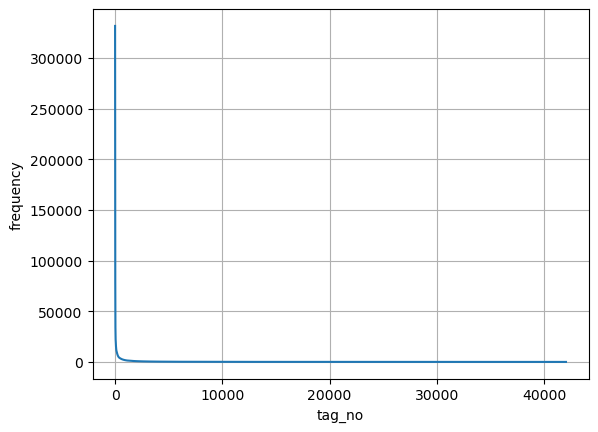

In [75]:
plt.plot(tag_counts)
plt.grid()
plt.xlabel('tag_no')
plt.ylabel('frequency')
plt.show()

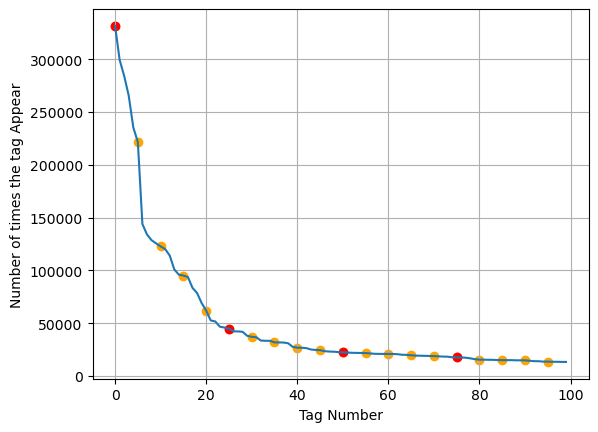

In [76]:
plt.plot(tag_counts[:100])
plt.scatter(x= list(range(0,100,5)), y = tag_counts[0:100:5], c= 'orange',label = "Quantiles with 5 % intervals")
plt.scatter(x= list(range(0,100,25)), y = tag_counts[0:100:25], c = "red", label = "Quantiles with 25th % intervals")
plt.grid()
plt.xlabel("Tag Number")
plt.ylabel("Number of times the tag Appear")
plt.show()

In [77]:
dict(result.items())

{'.a': 18,
 '.app': 37,
 '.asp.net-mvc': 1,
 '.aspxauth': 21,
 '.bash-profile': 138,
 '.class-file': 53,
 '.cs-file': 14,
 '.doc': 47,
 '.drv': 1,
 '.ds-store': 8,
 '.each': 184,
 '.emf': 33,
 '.exe': 27,
 '.exe.config': 1,
 '.hgtags': 6,
 '.htaccess': 14884,
 '.htpasswd': 61,
 '.ico': 10,
 '.lib': 20,
 '.lrc': 4,
 '.mobi': 2,
 '.mov': 16,
 '.net': 114087,
 '.net-1.0': 19,
 '.net-1.1': 218,
 '.net-2.0': 1661,
 '.net-3.0': 55,
 '.net-3.5': 3693,
 '.net-4.0': 5020,
 '.net-4.0-beta-2': 16,
 '.net-4.0-rc1': 6,
 '.net-4.5': 695,
 '.net-assembly': 516,
 '.net-authorization': 2,
 '.net-bcl': 2,
 '.net-bugs': 1,
 '.net-cf-3.5': 61,
 '.net-client-profile': 53,
 '.net-compact': 1,
 '.net-framework': 235,
 '.net-framework-source': 15,
 '.net-framework-version': 73,
 '.net-gadgeteer': 12,
 '.net-install': 7,
 '.net-internals': 4,
 '.net-interview': 3,
 '.net-micro-framework': 103,
 '.net-reflector': 24,
 '.net-remoting': 126,
 '.net-security': 13,
 '.net-services': 11,
 '.net2.0': 5,
 '.net3.5': 3

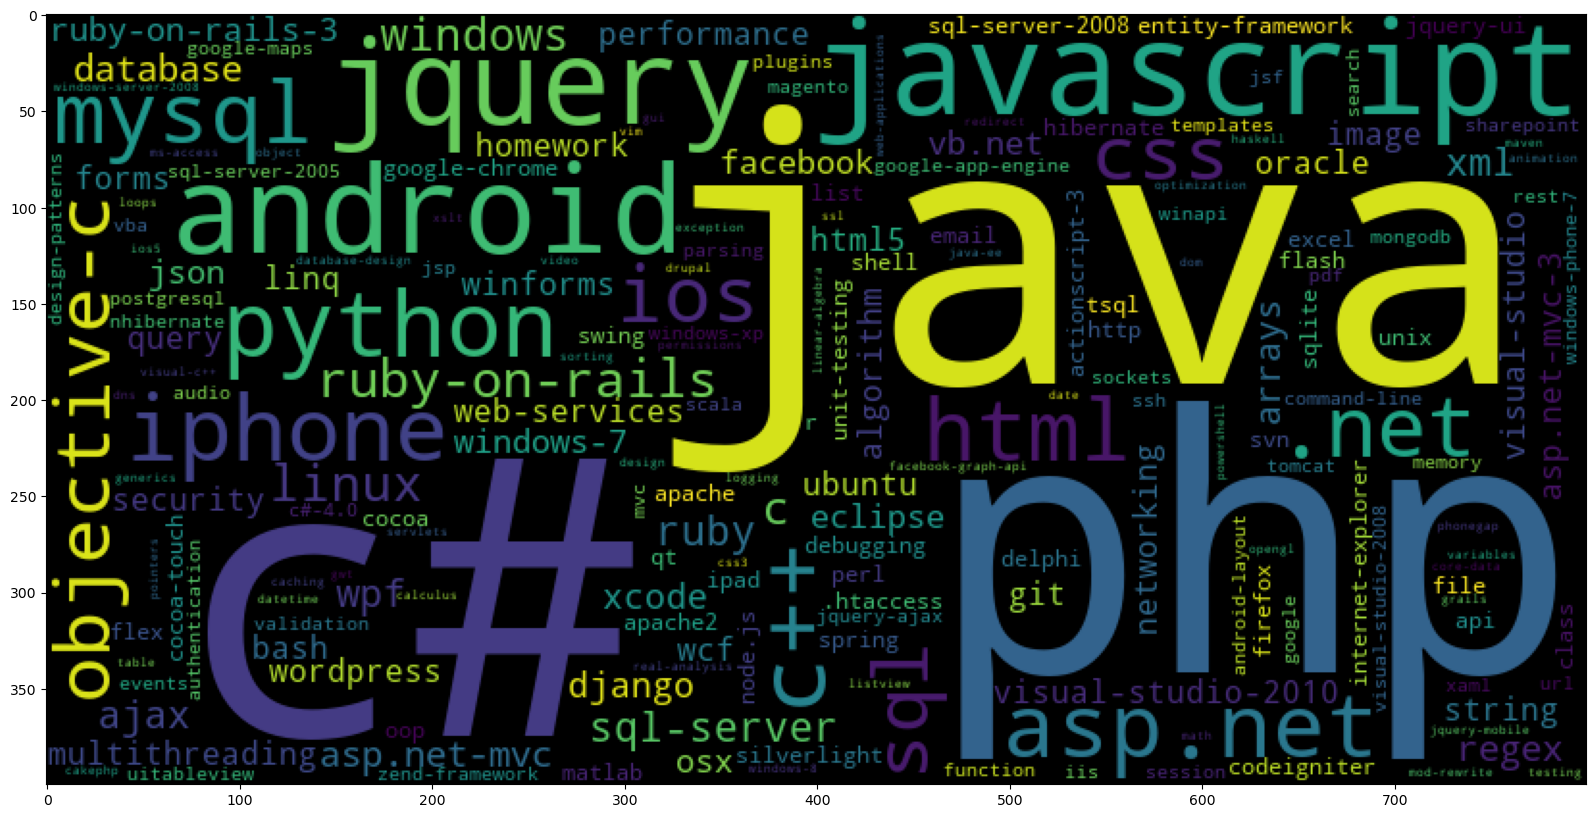

In [78]:
wordcloud = WordCloud(background_color='black',
         width = 800,
         height = 400).generate_from_frequencies(result)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.show()

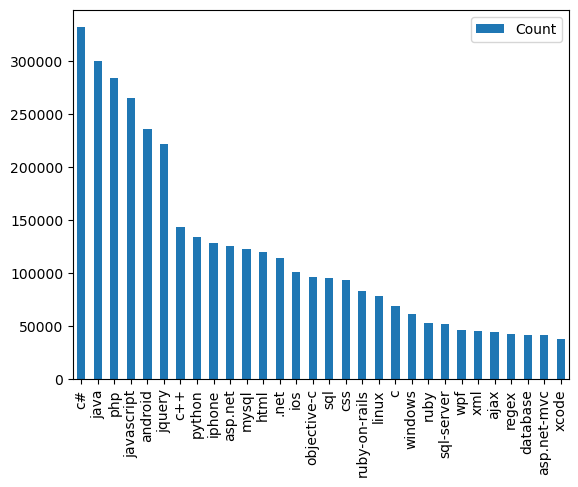

In [79]:
i = np.arange(30)
tags_df_sorted.head(30).plot(kind='bar')
plt.xticks(i, tags_df_sorted['Tags'][:30])
plt.show()

In [80]:
def striphtml(data):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr,' ',str(data))
    return cleantext

In [81]:
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

In [82]:
random_sample = df.sample(frac=0.01, random_state=42)

#taking a random sample for further use

In [83]:
random_sample.shape

(42063, 5)

In [84]:
random_sample.head()

,Id,Title,Body,Tags,tag_count
5950328,5950329,Is it safe to assign nullptr to a function poi...,<p>I created a function that accepts a functio...,c++ c++11 function-pointers,3
1056771,1056772,Android JavascriptInterface problem,<p>I am an Android beginner. I am trying to ch...,android user-interface webview textview,4
90268,90269,"Vertical slider, in which the filled bar chang...","<p>I've already looked at,</p>\n\n<p><a href=""...",asp.net-mvc-3 slider,2
465040,465041,Can a VS2010 VSPackage project be installed to...,<p>I am wondering whether the result VSIX arti...,visual-studio-2010 visual-studio-2008 vs-exten...,4
2727034,2727035,Shortcomings with Declarative Programming,<p>I've been reading through previous posts on...,research declarative,2


In [85]:
preprocessed_data_list=[]
questions_with_code=0
len_pre=0
len_post=0
questions_processed=0
prepared_df = pd.DataFrame(columns=['questions', 'code', 'tags', 'words_pre', 'words_post', 'is_code'])
for row in random_sample.iterrows():
    is_code=0
#initialized variables, created empty dataframe, and beginning iteration over rows of random_sample  

    title, question, tags = 3*(' '+row[1][1]), row[1][2], row[1][3]
    #assigning values to title, question and tags (keeping 3 times weight for the title)
    
    if '<code>' in question:
        questions_with_code+=1
        is_code=1
    x = len(question)+len(title)
    len_pre+=x
    #checked for code tag
    
    code = str(re.findall(r'<code>(.*?)</code>', question, flags=re.DOTALL))
    
    question = re.sub('<code>(.*?)</code>', '', question, flags=re.MULTILINE|re.DOTALL)
    question = striphtml(question.encode('utf-8'))
    
    title = title.encode('utf-8')
    
    question = str(title)+" "+str(question)
    question = re.sub(r'[^A-Za-z]+',' ', question)
    words = word_tokenize(str(question.lower()))
    
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))
    #preprocessing the question by removing code/html tags, encoding title and combining question and title, and then did further text cleaning
    
    len_post+=len(question)
    processed_di = {
        'question':question,
        "code":code,
        "tags":tags,
        "words_pre":x,
        "words_post":len(question),
        "is_code":is_code
    }
    #created processed dictionary
    
    prepared_df.loc[len(prepared_df.index)] = [question, code, tags, x, len(question), is_code]
    questions_processed+=1
    if(questions_processed%100000==0):
        print("number of questions completed=", questions_processed)
        
no_dup_avg_len_pre=(len_pre*1.0)/questions_processed
no_dup_avg_len_post=(len_post*1.0)/questions_processed

print( "Avg. length of questions(Title+Body) before processing: %d"%no_dup_avg_len_pre)
print( "Avg. length of questions(Title+Body) after processing: %d"%no_dup_avg_len_post)
print ("Percent of questions containing code: %d"%((questions_with_code*100.0)/questions_processed))
#Appended dict to dataframe, updated counters and then calculating and printing statistics
    
    





Avg. length of questions(Title+Body) before processing: 1273
Avg. length of questions(Title+Body) after processing: 399
Percent of questions containing code: 57


In [86]:
prepared_df.head()

,questions,code,tags,words_pre,words_post,is_code
0,safe assign nullptr function pointer variabl s...,['typedef CString(*GetLabelFunc)(const CSomeOb...,c++ c++11 function-pointers,1059,502,1
1,android javascriptinterfac problem android jav...,['public class MyWebActivity extends Activity ...,android user-interface webview textview,1739,358,1
2,vertic slider fill bar chang colour depend lar...,[],asp.net-mvc-3 slider,1446,594,0
3,vs vspackag project instal vs vs vspackag proj...,[],visual-studio-2010 visual-studio-2008 vs-exten...,565,302,0
4,shortcom declar program shortcom declar progra...,[],research declarative,713,375,0


In [87]:
final_df = prepared_df[['questions', 'tags']]

In [88]:
vectorizer = CountVectorizer(tokenizer = lambda text: text.split(), binary = True)
multilabel_y = vectorizer.fit_transform(final_df["tags"])

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [89]:
multilabel_y.shape

(42063, 12938)

In [90]:
def tags_to_choose(n):
    t = multilabel_y.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn=multilabel_y[:,sorted_tags_i[:n]]
    return multilabel_yn

def questions_explained_fn(n):
    multilabel_yn = tags_to_choose(n)
    x= multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

In [91]:
question_explained = []
total_tags = multilabel_y.shape[1]
total_qs = final_df.shape[0]

for i in range(500, total_tags, 100):
    question_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

/tmp/ipykernel_32/2286374233.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabel)


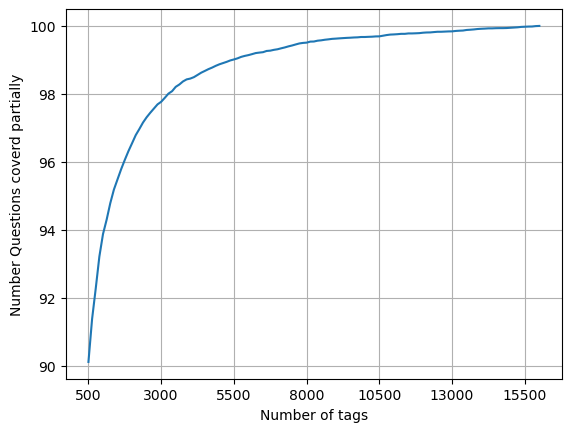

with  5500 tags we are covering  99.27 % of questions


In [92]:
fig, ax = plt.subplots()
ax.plot(question_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()
print("with ",5500,"tags we are covering ",question_explained[50],"% of questions")

In [93]:
multilabel_yx = tags_to_choose(5500)
print("number of questions not covered :", questions_explained_fn(5500),"out of ", total_qs)

number of questions not covered : 307 out of  42063


In [94]:
multilabel_yx.get_shape()

(42063, 5500)

In [95]:
print("Number of tags in sample :", multilabel_y.shape[1])
print("number of tags taken :", multilabel_yx.shape[1],"(",(multilabel_yx.shape[1]/multilabel_y.shape[1])*100,"%)")

Number of tags in sample : 12938
number of tags taken : 5500 ( 42.51043437934766 %)


In [96]:
total_size=final_df.shape[0]
train_size=int(0.80*total_size)

x_train=final_df.head(train_size)
x_test=final_df.tail(total_size - train_size)

y_train = multilabel_yx[0:train_size,:]
y_test = multilabel_yx[train_size:total_size,:]

In [97]:
tfidf_vect = TfidfVectorizer(min_df=0.00009,max_features=200000,smooth_idf=True,norm='l2',\
               tokenizer=lambda x : x.split(),sublinear_tf=False, ngram_range=(1,3) )

In [98]:
x_train_vectors = tfidf_vect.fit_transform(x_train['questions'])
x_test_vectors = tfidf_vect.transform(x_test['questions'])

In [99]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    warnings.filterwarnings("ignore", category=DeprecationWarning)

In [100]:
classifier = OneVsRestClassifier(SGDClassifier(loss='log_loss', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier.fit(x_train_vectors,y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 3401 is present in all training examples.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 3914 is present in all training examples.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 4108 is present in all training examples.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 4175 is present in all training examples.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 4297 is present in all training examples.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 4761 is present in all training examples.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 4847 is present in all 

OneVsRestClassifier(estimator=SGDClassifier(alpha=1e-05, loss='log_loss',
                                            penalty='l1'),
                    n_jobs=-1)

In [101]:
predictions = classifier.predict(x_test_vectors)

In [102]:
print("micro f1 score ", metrics.f1_score(y_test, predictions, average='micro'))

micro f1 score  0.39414492570743553
